<a href="https://www.kaggle.com/ninetyninenewton/prediction-of-stock-market-volatility?scriptVersionId=88441122" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Prediction of Volatility with Econometrics-Deep Learning Integrated Model   
### : Predicting VKOSPI with GARCH-RNN Model

In the era of uncertainty, the market volatility has never been higher. VIX, also known as the 'fear index' had hit record high in the midst of COVID-19. Predicting tomorrow's volatility is key to the future investment.  

Meanwhile, machine learning boom is overtaking every industry from automobile to retail. The machine learning solution is revolutionary; in other words, it has little respect to the conventional ways of doing things. This rigidness might come as a shortcoming in some cases.   

This notebook aims to predict market volatility. Instead of mere machine learning, it is integrated with a good ol' econometric(statistical) model. Data from Korean stock market during 2009 to 2019 was employed. The target data is VKOSPI which represents the volatility in Korean stock market.


[Link to dataset](https://www.kaggle.com/ninetyninenewton/vkospi)

### Volatility
The volatility $\sigma$, of a stock is a measure of our uncertainty about the returns provided by the stock. It can be defined as the standard deviation of the return provided by the stock. Volatility can be measured in several ways.
1. Historical Volatility  
> Historical volatility is calculated from historical data of a stock price.  

1. Implied Volatility  
> Implied volatility is calculated from options prices observed in the market. VKOSPI indicates implied volatility.

**Therefore, we**  
1. **Estimate historical volatility using econometric model.**  
1. **Close gap between historical volatility and implied volatility with option-related variables using deep learning.**

## 0. Setup

In [1]:
# Import packages
import os
import pickle

import numpy as np 
import pandas as pd 

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from scipy import stats
import scipy.optimize as optimize 

In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/volatility-index-around-the-world/CBOE Volatility Index Historical Data.csv
/kaggle/input/volatility-index-around-the-world/Nikkei Volatility Historical Data.csv
/kaggle/input/volatility-index-around-the-world/HSI Volatility Historical Data.csv
/kaggle/input/vkospi/options_KR.csv
/kaggle/input/optimize-res-trust/optimize_res_trust.pkl
/kaggle/input/dataset/test_org.pkl
/kaggle/input/dataset/train_org.pkl


## 1. Preprocess Data

### 1-1. Import data

In [3]:
# Import data - Korean Market Data
org_data = pd.read_csv("../input/vkospi/options_KR.csv")


# Import data - Volatility index around the world

CBOE_Volatility = pd.read_csv("../input/volatility-index-around-the-world/CBOE Volatility Index Historical Data.csv")
HSI_Volatility  = pd.read_csv("../input/volatility-index-around-the-world/HSI Volatility Historical Data.csv")
Nikkei_Volatility = pd.read_csv("../input/volatility-index-around-the-world/Nikkei Volatility Historical Data.csv")

CBOE_Volatility = CBOE_Volatility.loc[:,['Date','Price']]
HSI_Volatility = HSI_Volatility.loc[:,['Date','Price']]
Nikkei_Volatility = Nikkei_Volatility.loc[:,['Date','Price']]

In [4]:
org_data.head()

,Date,VKOSPI,KOSPI200,Open_interest,For_KOSPI_Netbuying_Amount,For_Future_Netbuying_Quantity,For_Call_Netbuying_Quantity,For_Put_Netbuying_Quantity,Indiv_Future_Netbuying_Quantity,Indiv_Call_Netbuying_Quantity,Indiv_Put_Netbuying_Quantity,PCRatio,Day_till_expiration,Day_of_a_week
0,2009-06-02,33.45,180.90,4377777,4.940000e+11,-4953,-24646,6581,1228,-466,31336,0.94,7,Tue
1,2009-06-03,32.66,180.47,4562690,-8.997074e+10,47,-57128,46851,399,127709,-22259,0.93,6,Wed
2,2009-06-04,32.56,180.31,4827524,-1.090000e+11,-7666,-2000,48883,5744,262558,10367,0.87,5,Thu
3,2009-06-05,32.95,175.75,5022921,9.842024e+10,969,64792,27196,-1688,79789,113935,0.89,4,Fri
4,2009-06-08,30.41,177.77,5293996,4.329179e+10,5797,10995,23123,-5534,97154,146244,0.81,3,Mon


In [5]:
CBOE_Volatility.head()

,Date,Price
0,"Nov 07, 2019",12.73
1,"Nov 06, 2019",12.62
2,"Nov 05, 2019",13.10
3,"Nov 04, 2019",12.83
4,"Nov 01, 2019",12.30


### 1-2. Convert date data

Convert date data into pd.datetime


In [6]:
# Convert date data

org_data['Date'] = pd.to_datetime(org_data['Date'])
CBOE_Volatility['Date'] = pd.to_datetime(CBOE_Volatility['Date'])
HSI_Volatility['Date'] = pd.to_datetime(HSI_Volatility['Date'])
Nikkei_Volatility['Date'] = pd.to_datetime(Nikkei_Volatility['Date'])

### 1-3. Preprocess time series data

Target data of Day n is predicted from the variables of Day n-1, except for 'Day_till_expiration' and 'Day_of_a_week' since they can be known in advance.  

It would be convenient to preprocess the dataframe so the input variables and the corresponding target variables are in the same row.

In [7]:
pivot = ['Date','VKOSPI','Day_till_expiration','Day_of_a_week']

# Save the original data
full_data = org_data.copy()

# Shift the pivot data
full_data[pivot] = full_data[pivot].shift(periods=-1)

# Drop the last row
full_data = full_data.drop(full_data.index[-1])

In [8]:
full_data.head()

,Date,VKOSPI,KOSPI200,Open_interest,For_KOSPI_Netbuying_Amount,For_Future_Netbuying_Quantity,For_Call_Netbuying_Quantity,For_Put_Netbuying_Quantity,Indiv_Future_Netbuying_Quantity,Indiv_Call_Netbuying_Quantity,Indiv_Put_Netbuying_Quantity,PCRatio,Day_till_expiration,Day_of_a_week
0,2009-06-03,32.66,180.90,4377777,4.940000e+11,-4953,-24646,6581,1228,-466,31336,0.94,6.0,Wed
1,2009-06-04,32.56,180.47,4562690,-8.997074e+10,47,-57128,46851,399,127709,-22259,0.93,5.0,Thu
2,2009-06-05,32.95,180.31,4827524,-1.090000e+11,-7666,-2000,48883,5744,262558,10367,0.87,4.0,Fri
3,2009-06-08,30.41,175.75,5022921,9.842024e+10,969,64792,27196,-1688,79789,113935,0.89,3.0,Mon
4,2009-06-09,30.46,177.77,5293996,4.329179e+10,5797,10995,23123,-5534,97154,146244,0.81,2.0,Tue


### 1-4. Format foreign volatility indices as input data

Like most of the other markets, Korean market is largely affected by global markets. Thus, volatility indices of major foreign markets can be helpful to predict the volatility of Korean market. Volatility indices of US(VIX), China(HSI), and Japan(Nikkei) markets are used here.

Considering that Seoul's timezone is ahead or the same of US, China, or Japan, 
any volatility index of the same day cannot be known in advance.   

Therefore, when predicting Day n, foreign volatility indices of Day n-1 are used.   
If Day n-1 is not avilable, Day n-2.     
If Day n-2 is not avilable, Day n-3, and so on.    


In [9]:
# Format foreign volatility indices as input data

def correspond_foreign_vol(date,data):
    """
    find the 'Price' of the date that is most recent to the given 'Date' in the 'data'
    """
    
    while True:
        date = date - pd.Timedelta('1 Day')  # go back one day 
        result_series = data['Price'].loc[data['Date']==date]  # find the 'Price' in the data that matches with the 'date'
        
        if not result_series.empty:  # if not empty (which means there is a row that matches with the 'date')
            result_series = result_series.reset_index()  # reset index
            result_value = result_series['Price'][0]  # and get the value
            return result_value

# Apply function

full_data['CBOE'] = full_data['Date'].apply(correspond_foreign_vol,data=CBOE_Volatility)
full_data['HSI'] = full_data['Date'].apply(correspond_foreign_vol,data=HSI_Volatility)
full_data['Nikkei'] = full_data['Date'].apply(correspond_foreign_vol,data=Nikkei_Volatility)

In [10]:
full_data[['Date','CBOE','HSI','Nikkei']].head()

,Date,CBOE,HSI,Nikkei
0,2009-06-03,29.63,39.66,32.75
1,2009-06-04,31.02,40.30,31.79
2,2009-06-05,30.18,40.38,32.48
3,2009-06-08,29.62,38.96,30.28
4,2009-06-09,29.77,39.57,30.79


## 2. Estimate historical volatility with GARCH model
GARCH, or GARCH(1,1) to be precise, is an widely used econometric model to estimate historical volatility.

GARCH estimates the historical volatility in Day n with: 
* **Rate of Return** (of an underlying asset) in Day n-1 (denoted by $ u $)
* **Volatility** in Day n-1 (denoted by $\sigma$)
* Note that $\sigma^{2}$ is often referred to **Variance**

There are three coefficients in the model:  
* **alpha**, coefficent of $ u^{2} $
* **beta**, coefficient of $ \sigma^{2} $
* **omega**, constant (It is actually not just a constant, but we will make it simple here.)

The formula for estimating (historical) volatility of Day n is:  
  
$$
\sigma^{2}_{n}= \omega + \alpha u^{2}_{n-1} + \beta \sigma^{2}_{n-1}
$$
  
  
    
All referenced from John C. Hull's "Options, Futures, And Other Derivatives (8th edition)".    

For more info,  
[GARCH Model](https://vlab.stern.nyu.edu/docs/volatility/GARCH)

### 2-1. Calculate return 
  
Calculate 'rate of return', or 'return' in short.  

The formula for return is the following, where $u$ denotes return and $S$ denotes the price of an underlying asset(e.g. stock). There is an another formula which involves logarithm, but this one will be used here.  
  
    
$$
u_{n} = \frac{S_{n} - S_{n-1}}{S_{n-1}}
$$


In [11]:
# Calculate return

KOSPI200_yesterday = org_data['KOSPI200'].shift(periods=1)  # Series made up of shifted KOSPI200
return_array = (org_data['KOSPI200']-KOSPI200_yesterday) / KOSPI200_yesterday  # Calculate return

### 2-2. Build GARCH model

Build a function which estimates the volatility of Day n with GARCH model.  
Following is a simple reminder of the formula.  

$$
\sigma^{2}_{n}= \omega + \alpha u^{2}_{n-1} + \beta \sigma^{2}_{n-1}
$$

In [12]:
# GARCH model
def garch_forward(return_rate,variance,coefficients):
    ''' data type: float, float, 1d array(length=3)'''
    
    # Coefficients
    alpha,beta,omega = coefficients
    # Calculate
    return omega + alpha*return_rate*return_rate + beta*variance

### 2-3. Choose the values for coefficients in the model - Build function

#### 2-3-1. Method

To estimate the volatility with the model, the values for the coefficients must be chosen. This is done with historical data by using "maximum likelihood method". This method involves maximizing the probability with which historical data occurs.   
  
It is assumed that the return at any Day n ($ u_{n}$) follows the nomral distribution with zero mean. Variance at each day is $v_{n}$. Therefore, a probability of observing $u_{n}$ is  
$$\frac{1}{\sqrt{2\pi v_{n}}} exp(\frac{-u_{i}^{2}}{2v_{n}})$$
  
Taking logarithms and ignoring constant multiplicative factors, the expression we wish to maximize in each day is the following.
$$-ln(v_{n})-\frac{u_{n}^{2}}{v_{n}}$$
  
Sum of the above expression over the data is what we finally want to maximize. 
  
  
#### 2-3-2. Values
* Return($u_{n}$) is calculated directly from the data. (This was done in 2-1.)  
* Variance($v_{n}$) is estimated by GARCH. Initial variance is set from the real VKOSPI value at that date.  
  
  **Variance($\sigma^{2}$)** represents 1 day.  
**VKSOPI** is an index of **volatility($\sigma$)** for 1 year expressed in percentage(%).  
Assuming there are 252 trading days per year, **VKOSPI** can be converted into **variance** by the following.  
  
$$
Variance = (VKOSPI)^{2} \: / \: (252 \times 100)
$$

In [13]:
# Set VKOSPI as an initial variance in the model

initial_vkospi = full_data['VKOSPI'][1] 
initial_variance = initial_vkospi*initial_vkospi/2520000 

In [14]:
# Function for optimization

def garch_for_optimization(array): 
    ''' data type: 1d array(length=3)'''
    
    # Coeffcients
    alpha,beta,omega = array 
    
    # Variables
    sum_probability = 0 # to maximize
    variance = initial_variance
    
    for i in range(1,return_array_train.shape[0]):  # exclude the first value because it's nan.
        return_rate = return_array_train[i]  
        
        # in case something goes wrong
        if variance<=0:
            print("Negative variance")
            break
        
        # calculate probability in a single day
        probability = -np.log(variance) - return_rate * return_rate / variance
        
        # add to the sum
        sum_probability += probability
        
        # calculate next day's variance by GARCH
        variance = garch_forward(return_rate,variance,array)
   
    return -sum_probability # note the sign(-); because scipy.optimize requires a function to be minimized

### 2-4. Choose the values for coefficients in the model - Optimize
  
Using scipy.optimize library, we optimize the function we built right before. 

NYU V-Lab's estimate (in Feb 15, 2020) was used for initial guess. The reason not simply taking V-Lab's estimate is because the ideal coefficients can differ by the time period. The bounds are set due to the underlying concept of GARCH, which will not be further explained here.

Since optimization consumes quite a time, the result is already pickled and you can load it.


In [15]:
# Optimize
# if execute is set TRUE, optimization which takes some time will be initiated
execute = False    

if execute:
    bounds = optimize.Bounds([0,0,0],[1,1,np.inf])
    initial_guess = [0.14,0.76,2.97]  # V-Lab's estimate

    # Trust-constr performed the best 
    optimize_res_trust = optimize.minimize(garch_for_optimization,initial_guess,method='trust-constr',bounds=bounds)

    # Pickle the result since it takes too much time
    with open('../input/optimize_res_trust.pkl','wb') as file:
        pickle.dump(optimize_res_trust,file)

In [16]:
# Load the pickle: optimize_res_trust
with open('/kaggle/input/optimize-res-trust/optimize_res_trust.pkl','rb') as file:
    optimize_res_trust = pickle.load(file)

# Optimization result
print('optimization result:')
print('alpha =',optimize_res_trust.x[0])
print('beta =',optimize_res_trust.x[1])
print('omega =',optimize_res_trust.x[2])

optimization result:
alpha = 0.04605549809734451
beta = 0.9364594541357646
omega = 1.5374604467160668e-06


### 2-5. Estimate historical volatility

Now the coefficients are chosen, we can estimate historical volatility of each day using GARCH model.  

In [17]:
# Estimate historical volatility with estimated coefficients

variance_array = np.zeros(full_data.shape[0],)  # Create array to store variance

# Values to be pre-assigned
variance_array[0] = np.nan  # Historical volatility cannot be estimated for the first one in full_data (06/03/2009)
variance_array[1] = initial_variance 

# Calculate historical volatilities using GARCH
for i in range(2,full_data.shape[0]):
    variance_array[i]=garch_forward(return_array[i-1],variance_array[i-1],optimize_res_trust.x)
    
# Adjust value to compare with VKOSPI (elaborated in 2-3-2)  
historical_volatility = np.sqrt(variance_array * 252) * 100

# Add to the dataset
full_data['Historical Volatility'] = historical_volatility
full_data = full_data.dropna()  # Drop NA (because of nan in historical volatility)

### 2-6. Result

Though prediction is not finished, it's worth visualizaing and calculating the error.  

In [18]:
# Before visualizing, few matplotlib settings
mpl.rcParams['axes.labelsize'] = 'x-large'
mpl.rcParams['axes.labelpad'] = 5.5  # space between axis and label
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.titlepad'] = '20.0'

mpl.rcParams['legend.fontsize'] = 'x-large'

# mpl color settings
default_clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']

# and seaborn settings
sns.set_style('darkgrid')

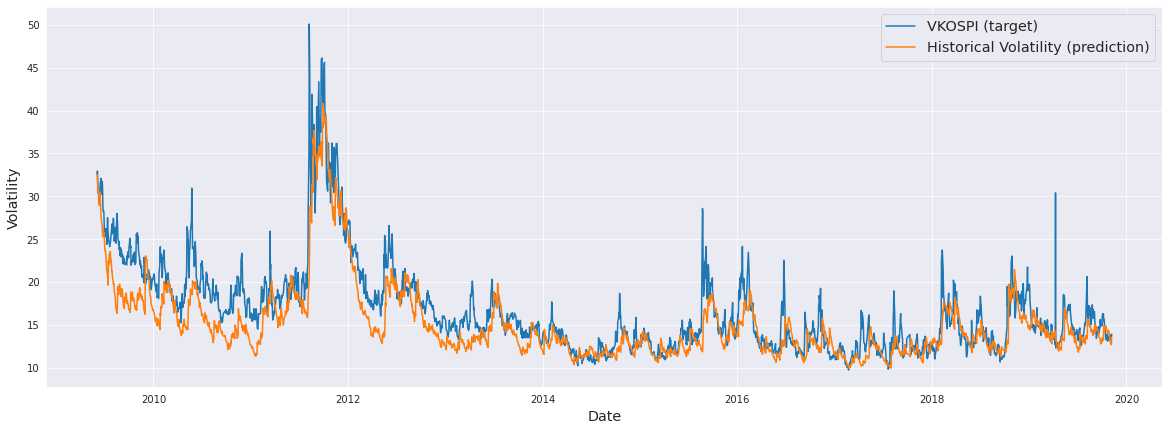

In [19]:
# Compare with VKOSPI (Visualization)
pd.plotting.register_matplotlib_converters()  # because of compatilbility issue with pd.Timestamp and matplotlib

fig, ax = plt.figure(figsize=(20,7)), plt.axes()
sns.lineplot(data=full_data,x='Date',y='VKOSPI',label='VKOSPI (target)',ax=ax)
sns.lineplot(data=full_data,x='Date',y='Historical Volatility',label='Historical Volatility (prediction)',ax=ax)
plt.ylabel('Volatility')
plt.show()

In [20]:
# Calculate error
abs_garch = abs(full_data['VKOSPI']-full_data['Historical Volatility'])
square_garch = (full_data['VKOSPI']-full_data['Historical Volatility'])**2

print('Total set')
print('MAE:',abs_garch.mean())
print('RMSE:',square_garch.mean()**0.5)

print('\nTest set ([-516:])')
print('MAE:',abs_garch[-516:].mean())
print('RMSE:',square_garch[-516:].mean()**0.5)

Total set
MAE: 2.0244055579708444
RMSE: 2.921748928446023

Test set ([-516:])
MAE: 1.3333841753810325
RMSE: 1.996354440392576


## 3. Exploratory Data Analysis
  
In this section, we examine and visualize various market variables to see whether they qualify as an input variable of the nerual network. 


1. Day of a week 
> `'Day_of_a_week'`
1. Foreign volatility indices  
> `'CBOE'` `'HSI'` `'Nikkei'`
1. Days left untill expiration date 
>`'Day_till_expiration'`
1. Other market variables
>`'KOSPI200','Open_interest','For_KOSPI_Netbuying_Amount','For_Future_Netbuying_Quantity',
 'For_Call_Netbuying_Quantity','For_Put_Netbuying_Quantity','Indiv_Future_Netbuying_Quantity',
 'Indiv_Call_Netbuying_Quantity','Indiv_Put_Netbuying_Quantity','PCRatio'`

In [21]:
# Split data into train data(including validation data) and test data
split_ratio = 0.8

data = full_data.set_index('Date')
len_data = full_data.shape[0]

train_org = full_data.iloc[:int(len_data*split_ratio),]
test_org = full_data.iloc[int(len_data*split_ratio):,]

print('train set',train_org.shape)
print('test set',test_org.shape)

train set (2062, 18)
test set (516, 18)


### 3-1. Day of a week ('Day_of_a_week')


The correlation seems to be statistically insignificant. 

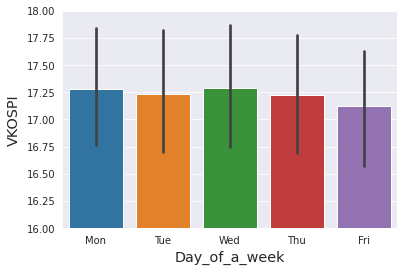

In [22]:
# 1. Day of a week
# confidence interval = 95%
barplot = sns.barplot(x='Day_of_a_week',y='VKOSPI',data=train_org,ci=95,order=['Mon','Tue','Wed','Thu','Fri']) 
barplot.set_ylim((16,18))
plt.show()

### 3-2. Foreign volatility indices ('CBOE', 'HSI',  'Nikkei')
1. ```VKOSPI(KOSPI200,South Korea)``` has the highest correlation with ```VIX(S&P500,US)```, just like the rest of the world.  
(VIX is denoted by `'CBOE'` in the code, in which VIX is calculated and disseminated.) 
2. ```VHSI(HSI,Hong Kong)``` follows, as Korean economy is highly dependent on Chinese economy.  
3. ```JNVI(Nikkei,Japan)``` then follows.  

Considering the high correlations with each other, we're only including `'CBOE'(VIX)`.  



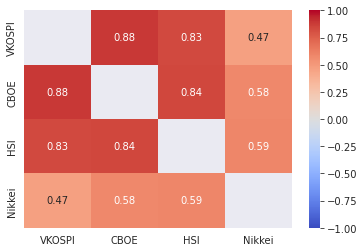

In [23]:
# 2. Foreign volatility indices
corr = train_org.loc[:,['VKOSPI','CBOE','HSI','Nikkei']].corr()

# heatmap
mask = np.zeros_like(corr)
for i in range(mask.shape[0]):
    mask[i,i]=True
sns.heatmap(corr,annot=True,mask=mask,cmap='coolwarm',vmin=-1,vmax=1)
plt.show()

### 3-3. Days left untill expiration date ('Day_till_expiration')

We will include `Day_till_expiration`.

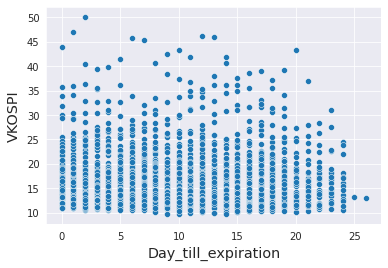

Too bizarre when VKOSPI is small.
Instead of plotting every data, plot mean of VKOSPI within each Day_till_expiration.


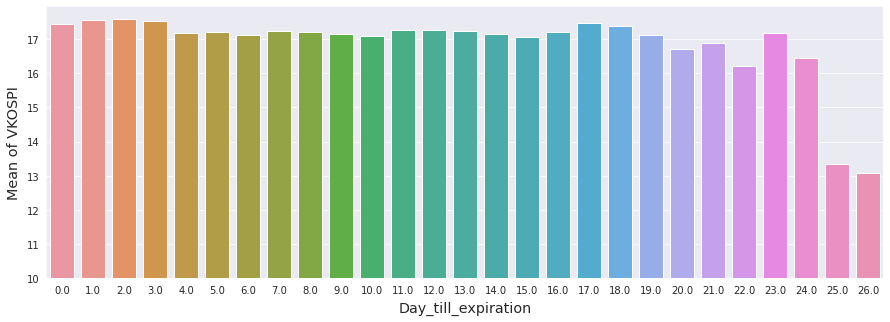

It is reasonable to suspect that there aren't much data when day_till_expiration is high


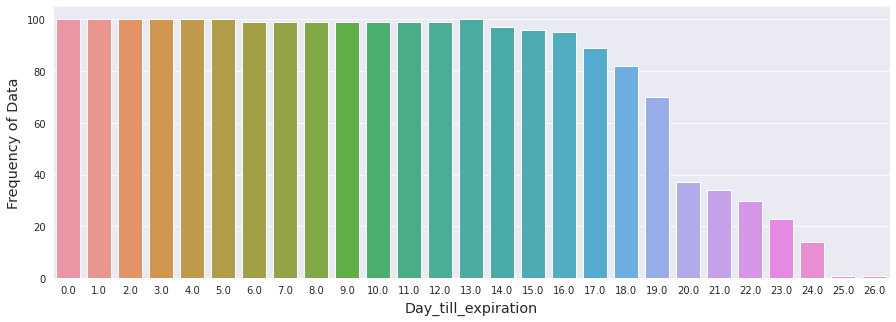

The amount of data seems to be insufficient when Day_till_expiration is high


In [24]:
# start with simple scatterplot
sns.scatterplot(x='Day_till_expiration',y='VKOSPI',data=train_org)
plt.show()

# too bizarre when VKOSPI is small.
print('Too bizarre when VKOSPI is small.')
print('Instead of plotting every data, plot mean of VKOSPI within each Day_till_expiration.')
      
mean_by_dtexp = train_org.groupby('Day_till_expiration').mean()['VKOSPI']
plt.figure(figsize=(15,5))
plt.ylabel('Mean of VKOSPI')
mean_by_dtexp_plot = mean_by_dtexp - 10  # for plotting purpose
sns.barplot(x=mean_by_dtexp.index,y=mean_by_dtexp_plot.values,bottom=10)
plt.show()

# reasonable to suspect that there aren't much data with very high day_till_expiration
print('It is reasonable to suspect that there aren\'t much data when day_till_expiration is high')
len_by_dtexp = train_org['Day_till_expiration'].value_counts()
plt.figure(figsize=(15,5))
plt.xlabel('Day_till_expiration')
plt.ylabel('Frequency of Data')
sns.barplot(x=len_by_dtexp.index,y=len_by_dtexp.values)
plt.show()

print('The amount of data seems to be insufficient when Day_till_expiration is high')

In [25]:
# Exclude the cases with insufficient amount of data

def slice_and_anaylze(slice_at):
    # slice dataframe till the given parameter(slice_at)
    
    print(f'Plot from 0 to {slice_at}.')
    mean_by_dtexp = full_data.groupby('Day_till_expiration').mean()['VKOSPI']
    mean_by_dtexp = mean_by_dtexp[:slice_at]  # slice
    mean_by_dtexp = pd.DataFrame({'Day_till_expiration':mean_by_dtexp.index,
                                  'Mean_of_VKOSPI':mean_by_dtexp.values})  # Convert series to dataframe (for sns plot)
    
    # lmplot
    sns.lmplot(x='Day_till_expiration',y='Mean_of_VKOSPI',data=mean_by_dtexp)
    plt.show()

    # correlation test (pearson)
    corr_coef = stats.pearsonr(mean_by_dtexp['Day_till_expiration'],mean_by_dtexp['Mean_of_VKOSPI'])
    print('Pearson correlation test')
    print('='*50)
    print('correlation coefficient:',corr_coef[0])
    print('2-tailed p-value:', corr_coef[1])

It isn't clear how much data is sufficient enough. Hereby we test a couple of cases.  

1. 0~24  
> This case excludes only 25 and 26, in which there is almost no data at all. 

1. 0~19  
> This case only includes ones with more than 50 days, which is the half of maximum.

Plot from 0 to 24.


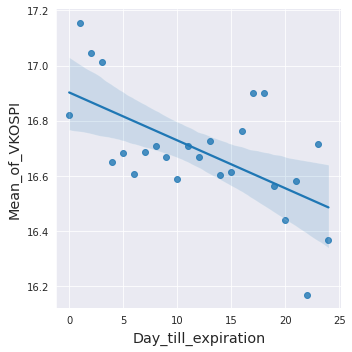

Pearson correlation test
correlation coefficient: -0.6085244287977164
2-tailed p-value: 0.0012479084198704369


In [26]:
#~24
slice_and_anaylze(24)

Plot from 0 to 19.


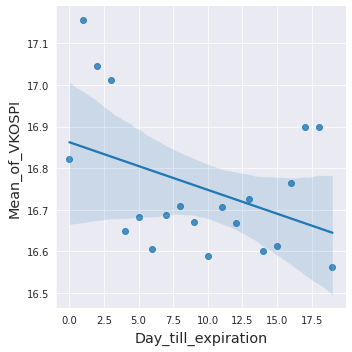

Pearson correlation test
correlation coefficient: -0.4055469889294405
2-tailed p-value: 0.07605984144803461


In [27]:
#~19
slice_and_anaylze(19)

> It's hard to determine how much data is needed to consider mean of VKOSPI valid.     
  
> However, the first analysis(\~24) definitely shows the correlation between **the days left until expiration date** and **VKOSPI**.   
Even the second analysis(\~19) wasn't so bad. 

Therefore, it's reasonable to think that correlation is statistically significant, or at least **this variable can be fed into a neural network later on**.  

### 3-4. Other market variables
`'KOSPI200','Open_interest','For_KOSPI_Netbuying_Amount','For_Future_Netbuying_Quantity',
 'For_Call_Netbuying_Quantity','For_Put_Netbuying_Quantity','Indiv_Future_Netbuying_Quantity',
 'Indiv_Call_Netbuying_Quantity','Indiv_Put_Netbuying_Quantity','PCRatio'`
 
 
> Only `KOSPI200` seems to have linear correlation with `VKOSPI`
  
> Within the variables, only `Indiv_Future_Netbuying_Quantity` and `For_Future_Netbuying_Quantity` seems to have correlation with each other. However, it seems unnecessary to exclude one of the variables from the poteintial neural net input variables.

Since visualization doesn't reveal everything, we will not entirely exclude these variables.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/s

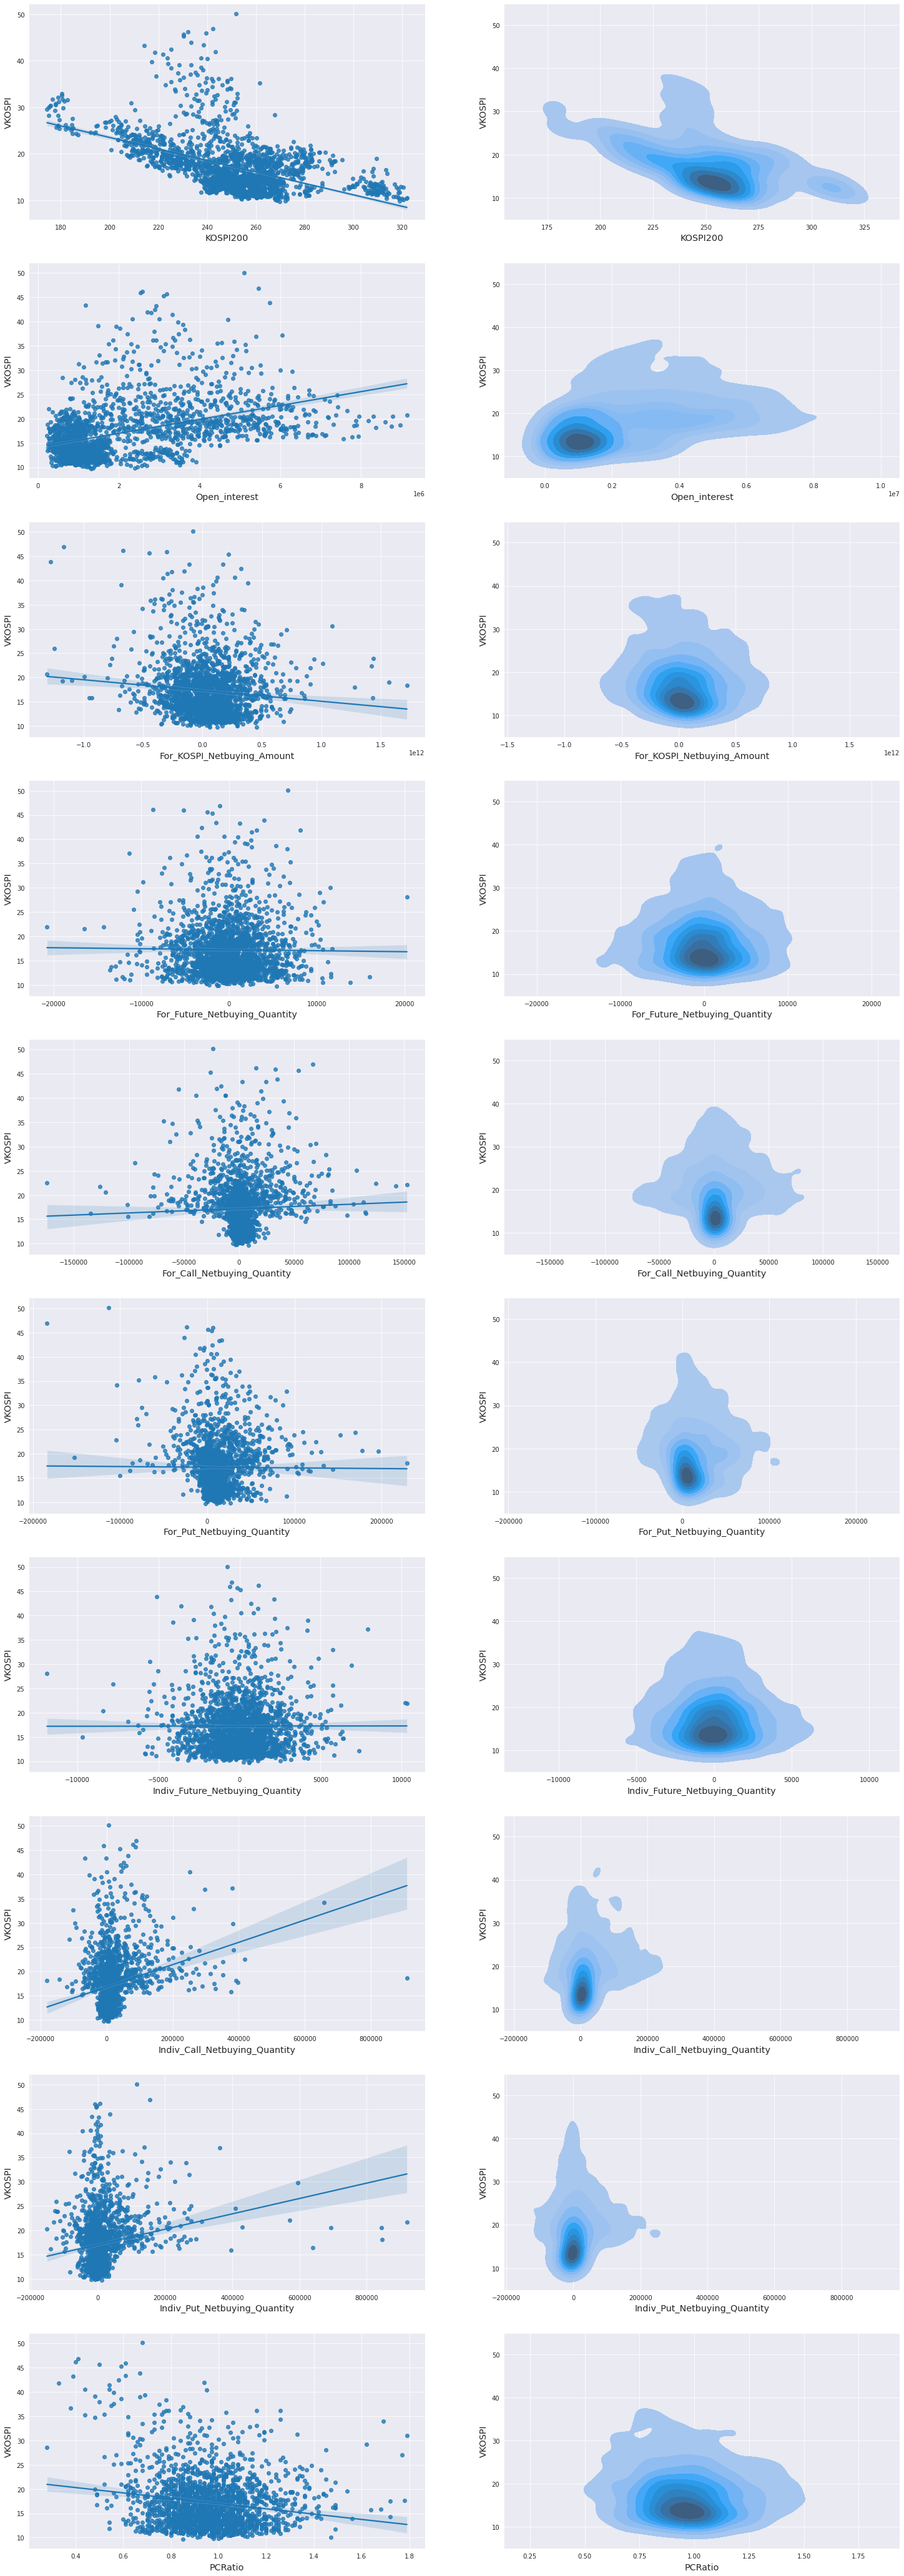

In [28]:
# Plot each market variable with VKOSPI

# Columns to plot 
plot_columns = ['KOSPI200','Open_interest','For_KOSPI_Netbuying_Amount','For_Future_Netbuying_Quantity',
                'For_Call_Netbuying_Quantity','For_Put_Netbuying_Quantity','Indiv_Future_Netbuying_Quantity',
                'Indiv_Call_Netbuying_Quantity','Indiv_Put_Netbuying_Quantity','PCRatio']

# plot
fig, axes = plt.subplots(10,2,figsize=(25,75))
for i,col in enumerate(plot_columns):
    sns.regplot(col,'VKOSPI',data=train_org, ax=axes[i,0]) # regression plot
    sns.kdeplot(train_org[col],train_org['VKOSPI'],shade=True, ax=axes[i,1]) # kernel density estimate plot
  

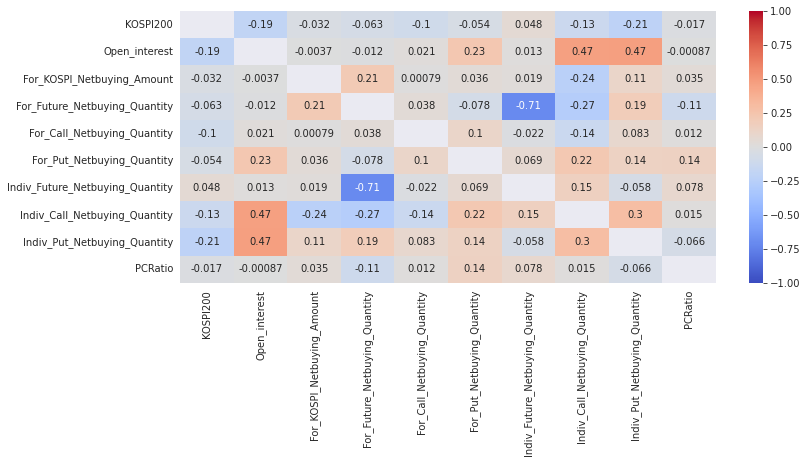

In [29]:
# Correlation matrix
corr = train_org[plot_columns].corr()

mask = np.zeros_like(corr)
for i in range(mask.shape[0]):
    mask[i,i]=True
plt.figure(figsize=(12,5))
sns.heatmap(corr,annot=True,mask=mask,cmap='coolwarm',vmin=-1,vmax=1)
plt.show()

correlation coefficient: -0.7068176593588511


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


correlation coefficient: 0.47489292396381133


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


correlation coefficient: 0.2963550250899931


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


correlation coefficient: 0.46636683677847024


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 432x288 with 0 Axes>

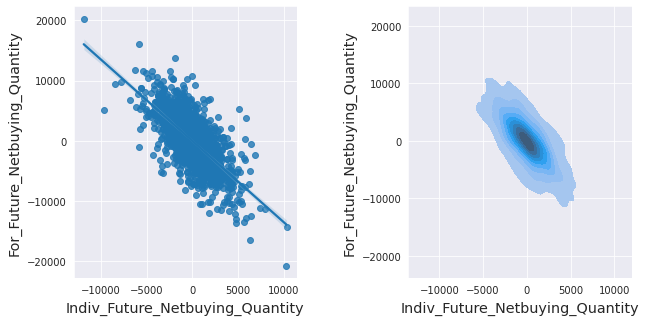

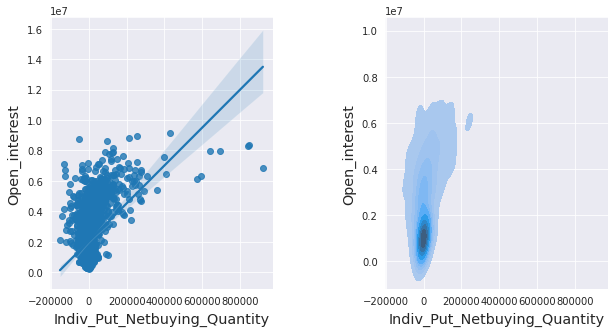

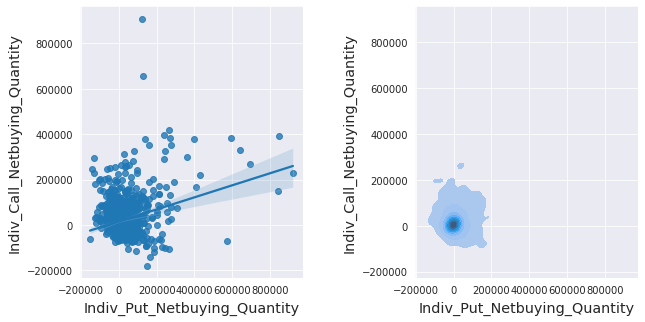

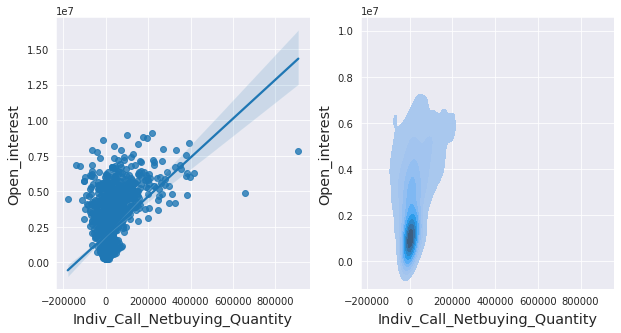

In [30]:
# Plot variables with high correlation coefficient

def cor_reg_kde(x,y,data):
    # Correlation coefficient
    print('correlation coefficient:',corr.loc[x,y])
    
    # Subplot adjust
    plt.subplots_adjust(wspace=0.5)
    
    # Plot (regression and kernel density)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    sns.regplot(x,y,data=data,ax=ax1)
    sns.kdeplot(data[x],data[y],shade=True,ax=ax2)
    
cor_reg_kde('Indiv_Future_Netbuying_Quantity','For_Future_Netbuying_Quantity',train_org)
cor_reg_kde('Indiv_Put_Netbuying_Quantity','Open_interest',train_org)
cor_reg_kde('Indiv_Put_Netbuying_Quantity','Indiv_Call_Netbuying_Quantity',train_org)
cor_reg_kde('Indiv_Call_Netbuying_Quantity','Open_interest',train_org)

## 4. Data Preprocessing for Neural Net
In this section, we preprocess data before feeding into neural network.

### 4-1. Normalize data

In [31]:
# Normalize data

# Keep the original
train = train_org.copy()
test = test_org.copy()

# Variables that has to be normalized
to_normalize = ['VKOSPI','KOSPI200', 'Open_interest',
                  'For_KOSPI_Netbuying_Amount', 'For_Future_Netbuying_Quantity',
                  'For_Call_Netbuying_Quantity', 'For_Put_Netbuying_Quantity',
                  'Indiv_Future_Netbuying_Quantity', 'Indiv_Call_Netbuying_Quantity',
                  'Indiv_Put_Netbuying_Quantity', 'PCRatio', 'Day_till_expiration',
                  'CBOE','Historical Volatility'
                 ]
# Normalize
mean_train = train[to_normalize].mean()
std_train = train[to_normalize].std()

train[to_normalize] = (train[to_normalize]-mean_train)/std_train
test[to_normalize] = (test[to_normalize]-mean_train)/std_train

### 4-2. Select input variables

In [32]:
# Select input variables
input_var = ['KOSPI200', 'Open_interest','Day_till_expiration', 'CBOE', 'Historical Volatility',
             'For_KOSPI_Netbuying_Amount','For_Future_Netbuying_Quantity',
             'For_Call_Netbuying_Quantity','For_Put_Netbuying_Quantity',
             'Indiv_Future_Netbuying_Quantity', 'Indiv_Call_Netbuying_Quantity',
            'Indiv_Put_Netbuying_Quantity'
            ] 
print(f'total {len(input_var)} variables')

# Subsample data
x_train_org = train[input_var]
x_test_org = test[input_var]
y_train_org = train['VKOSPI']
y_test_org = test['VKOSPI']

print('x_train_org', x_train_org.shape)
print('y_train_org', y_train_org.shape)
print('x_test_org', x_test_org.shape)
print('y_test_org', y_test_org.shape)

total 12 variables
x_train_org (2062, 12)
y_train_org (2062,)
x_test_org (516, 12)
y_test_org (516,)


### 4-3. Reshape data
* We set our **time steps to be 4**.   
* This means that we predict the VKOSPI with previous data from **last 5 days**.   
* It's 5, not 4, because we already shifted 1 day before EDA (in 1-3). 
* 5 days usually represent one week. (excluding weekend)
  
Shape of reshpaed data is ***(batch_size, time_steps, number_of_feautures)***.   
  
  
`number of features` will remain the same.    
`time steps` will be set to 4.

In [33]:
TIME_STEPS = 4  #predict with 5 days (+1 because we already shifted 1 day in 1-3)

# function
def reshape(data, time_steps = TIME_STEPS):
    stack = [data.iloc[i:i+time_steps].to_numpy() for i in range(len(data)-time_steps)]
    reshaped = np.stack(stack, axis=0) 
    return reshaped

# reshape
x_train_val = reshape(x_train_org) # train data and validation data
y_train_val = reshape(y_train_org)
x_test = reshape(x_test_org)
y_test = reshape(y_test_org)

print('x_train + x_val', x_train_val.shape)
print('y_train + y_val', y_train_val.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train + x_val (2058, 4, 12)
y_train + y_val (2058, 4)
x_test (512, 4, 12)
y_test (512, 4)


### 4-4. Seperate validation data from train data

In [34]:
# Seperate validation data from train data
i = int(len(x_train_val) * 0.8)

x_train = x_train_val[:i]
x_val = x_train_val[i:]
y_train = y_train_val[:i]
y_val = y_train_val[i:]

print('train data:', x_train.shape[0])
print('validation data:', x_val.shape[0])
print('test data:', x_test.shape[0])

train data: 1646
validation data: 412
test data: 512


## 5. Neural Network
In this section, we build a neural network which includes historical volatility as an input variable.  
Other option-related variables are also included in order to predict implied volatility.
  
  
We will use a couple of different neural network.
1. Vanilla NN
2. LSTM
3. GRU

### 5-1. Hyperparameter tuning
Bayesian optimization will be applied using `kerastuner`.

In [35]:
from kerastuner import BayesianOptimization

# Function 'model_builder' builds and compiles neural network with given hyperparameters

# vanilla nn
def nn_builder(hp):
    # hp
    UNITS = hp.Int('UNITS', min_value = 16, max_value = 128, step = 16)
    ACTIVATION_1 = hp.Choice('ACTIVATION',values = ['relu','linear','tanh'])
    ACTIVATION_2 = hp.Choice('ACTIVATION',values = ['relu','linear','tanh'])
    
    # model instance
    model = keras.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(units = UNITS, activation = ACTIVATION_1),
        keras.layers.Dropout(rate = 0.2),
        keras.layers.Dense(1, activation = ACTIVATION_2)
    ])
    
    # compile
    model.compile(optimizer = keras.optimizers.Adam(),
                  loss = 'mse', metrics = ['mae'])    
    
    return model

# lstm
def lstm_builder(hp):
    # hp
    UNITS_1 = hp.Int('UNITS_1', min_value = 16, max_value = 128, step = 16)
    UNITS_2 = hp.Int('UNITS_2', min_value = 8, max_value = 32, step = 8)
    ACTIVATION = hp.Choice('ACTIVATION',values = ['relu','linear','tanh'])
    
    # model instance
    model = keras.Sequential([
        # input_shape = (time_steps, # of features)
        keras.layers.LSTM(units = UNITS_1, input_shape = (None, x_train.shape[2]), return_sequences = False), 
        keras.layers.Dense(UNITS_2, activation = ACTIVATION),
        keras.layers.Dropout(rate = 0.2),
        keras.layers.Dense(1, activation = 'linear')
    ])
    
    # compile
    model.compile(optimizer = keras.optimizers.Adam(),
                  loss = 'mse', metrics = ['mae'])
    
    return model

# gru
def gru_builder(hp):
    # hp
    UNITS_1 = hp.Int('UNITS_1', min_value = 16, max_value = 128, step = 16)
    UNITS_2 = hp.Int('UNITS_2', min_value = 8, max_value = 32, step = 8)
    ACTIVATION = hp.Choice('ACTIVATION',values = ['relu','softmax','linear'])
    
    # model instance
    model = keras.Sequential([
        # input_shape = (time_steps, # of features)
        keras.layers.GRU(units = UNITS_1, input_shape = (None, x_train.shape[2]), return_sequences = False),
        keras.layers.Dense(UNITS_2, activation = ACTIVATION),
        keras.layers.Dropout(rate = 0.2),
        keras.layers.Dense(1, activation = 'linear')
    ])
    
    # compile
    model.compile(optimizer = keras.optimizers.Adam(),
                  loss = 'mse', metrics = ['mae'])
    
    return model

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [36]:
# Implement earlystopping with keras callback 

PATIENCE = 5 # number of epochs with no improvement after which training will be stopped.

Earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              min_delta = 0.001,
                                              patience=PATIENCE, 
                                              mode='min', 
                                              restore_best_weights=True)

In [37]:
# Search hyperparameters
SEED = 121

# NN
tuner_nn = BayesianOptimization(nn_builder,
                                objective = 'val_loss',
                                max_trials = 20,
                                seed = SEED,
                                directory = 'kerastuner',
                                overwrite = True
                                )

tuner_nn.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val), verbose=0, callbacks=[Earlystopping])

## Build model based on the optimized hyperparameters
besthp_nn = tuner_nn.get_best_hyperparameters()[0]
model_nn = tuner_nn.hypermodel.build(besthp_nn)


# lstm
tuner_lstm = BayesianOptimization(lstm_builder,
                            objective = 'val_loss',
                            max_trials = 20,
                            seed = SEED,
                            directory = 'kerastuner')

tuner_lstm.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val), verbose=0, callbacks=[Earlystopping])

## Build model based on the optimized hyperparameters
besthp_lstm = tuner_lstm.get_best_hyperparameters()[0]
model_lstm = tuner_lstm.hypermodel.build(besthp_lstm)


# gru
tuner_gru = BayesianOptimization(gru_builder,
                            objective = 'val_loss',
                            max_trials = 20,
                            seed = SEED,
                            directory = 'kerastuner')

tuner_gru.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val), verbose=0, callbacks=[Earlystopping])

## Build model based on the optimized hyperparameters
besthp_gru = tuner_gru.get_best_hyperparameters()[0]
model_gru = tuner_gru.hypermodel.build(besthp_gru)




2022-02-22 05:09:07.457537: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-02-22 05:09:07.990680: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [38]:
besthp_nn

### 5-2. Train model

In [39]:
# Colors designated to each model
palette = default_clrs[:4]
palette.append(default_clrs[6])

**PALETTE**
* 0: target data (VKOSPI)
* 1: GARCH (benchmark)
* 2: GARCH-NN
* 3: GARCH-LSTM
* 4: GARCH-GRU

In [40]:
# Ensure reproducible result
print(SEED)
tf.random.set_seed(SEED)

121


final loss: 0.24560092389583588
final val_loss: 0.07626797258853912


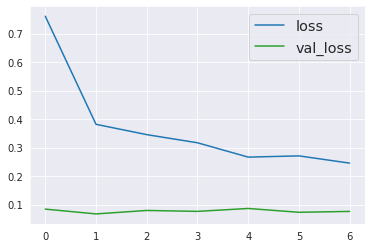

In [41]:
# Train model - NN
history = model_nn.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0, callbacks=[Earlystopping])

# Plot loss
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss', color=palette[2])
plt.legend()

# Loss
print('final loss:',history.history['loss'][-1])
print('final val_loss:',history.history['val_loss'][-1])

In [42]:
model_nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               6272      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 6,401
Trainable params: 6,401
Non-trainable params: 0
_________________________________________________________________


final loss: 0.15484173595905304
final val_loss: 0.11756324023008347


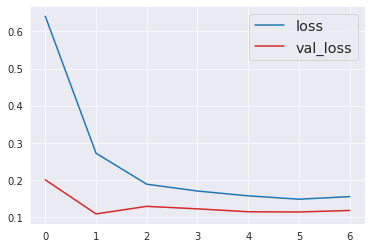

In [43]:
# Train model - LSTM
history = model_lstm.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0, callbacks=[Earlystopping])

# Plot loss
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss',color=palette[3])
plt.legend()

# Loss
print('final loss:',history.history['loss'][-1])
print('final val_loss:',history.history['val_loss'][-1])

In [44]:
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


final loss: 0.14174887537956238
final val_loss: 0.059321362525224686


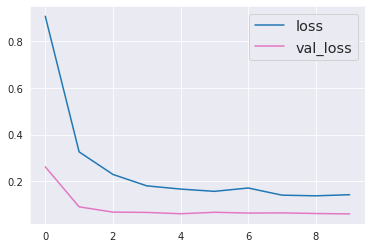

In [45]:
# Train model - GRU
history = model_gru.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0, callbacks=[Earlystopping])

# Plot loss
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss',color=palette[4])
plt.legend()

# Loss
print('final loss:',history.history['loss'][-1])
print('final val_loss:',history.history['val_loss'][-1])

In [46]:
model_gru.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 16)                1440      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 1,585
Trainable params: 1,585
Non-trainable params: 0
_________________________________________________________________


## 6. Result

In [47]:
# Data for comparison
target_date = test_org['Date'].iloc[TIME_STEPS:] 
target_vkospi = test_org['VKOSPI'].iloc[TIME_STEPS:]
predictions_hv = test_org['Historical Volatility'].iloc[TIME_STEPS:]

# Function to scale back predictions
def scale_back(predictions):
    predictions = [prediction[0] for prediction in predictions] # unpack array

    # scale back
    mean_vol = train_org['VKOSPI'].mean()
    std_vol = train_org['VKOSPI'].std() 
    predictions = [prediction * std_vol + mean_vol for prediction in predictions]
    
    return predictions

# Predict
predictions_nn = scale_back(model_nn.predict(x_test))
predictions_lstm = scale_back(model_lstm.predict(x_test))
predictions_gru = scale_back(model_gru.predict(x_test))

# pd.Series-ization
predictions_nn = pd.Series(predictions_nn, index=target_vkospi.index, name='predictions_nn')
predictions_lstm = pd.Series(predictions_lstm, index=target_vkospi.index, name='predictions_lstm')
predictions_gru = pd.Series(predictions_gru, index=target_vkospi.index, name='predictions_gru')

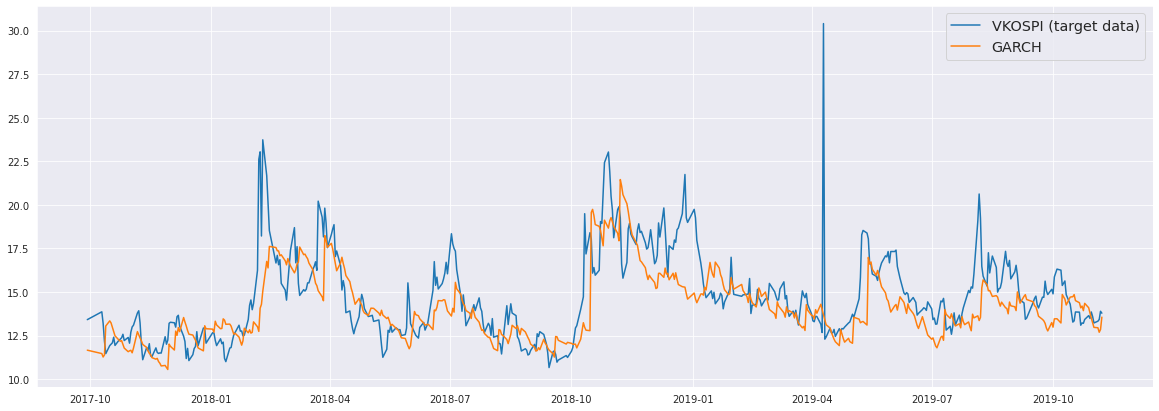

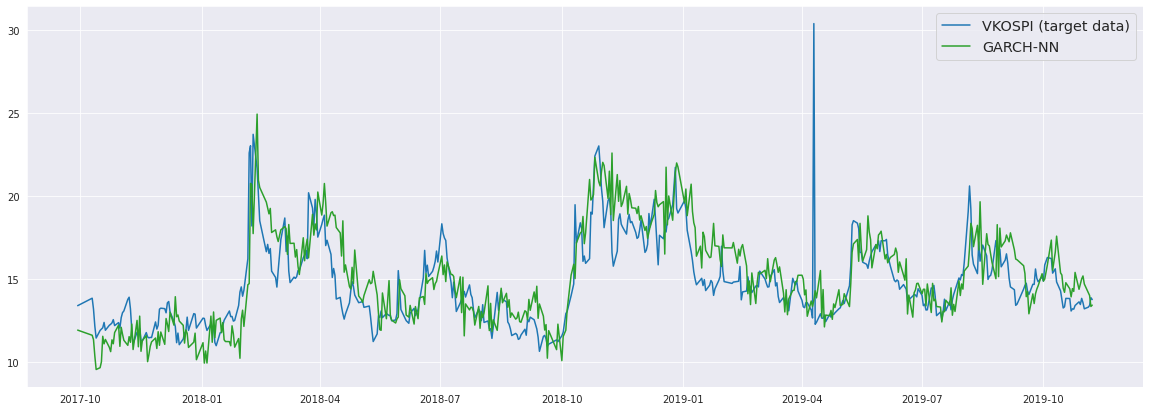

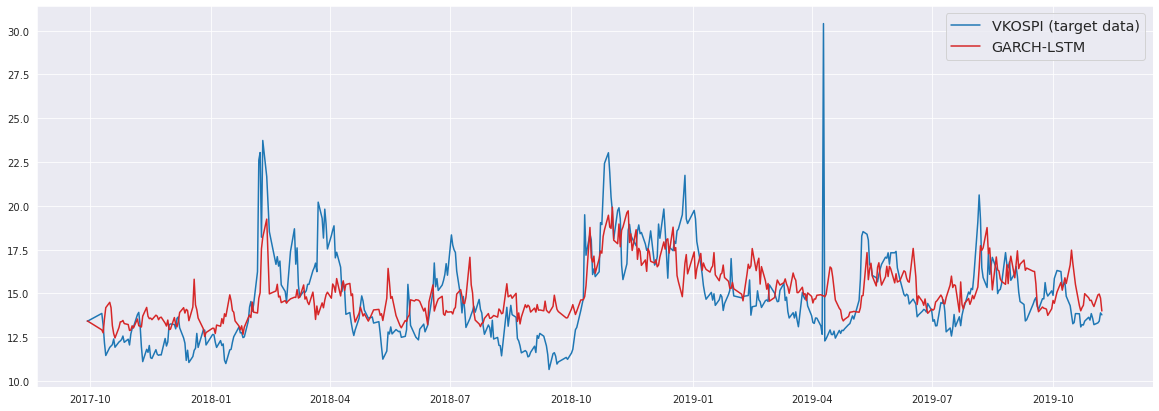

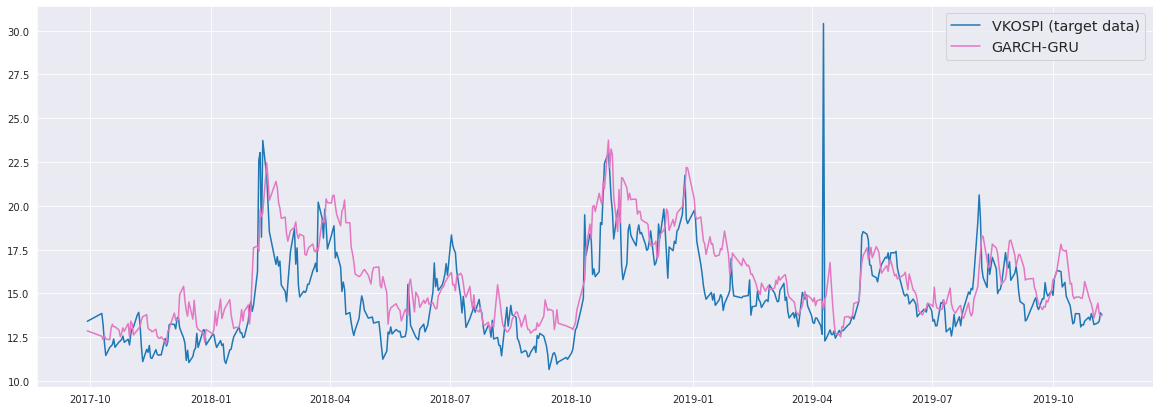

In [48]:
# Plot
fig1, ax1 = plt.figure(figsize=(20,7)), plt.axes()
fig2, ax2 = plt.figure(figsize=(20,7)), plt.axes()
fig3, ax3 = plt.figure(figsize=(20,7)), plt.axes()
fig4, ax4 = plt.figure(figsize=(20,7)), plt.axes()

# target data
ax1.plot(target_date, target_vkospi, label='VKOSPI (target data)')
ax2.plot(target_date, target_vkospi, label='VKOSPI (target data)')
ax3.plot(target_date, target_vkospi, label='VKOSPI (target data)')
ax4.plot(target_date, target_vkospi, label='VKOSPI (target data)')

# predictions
ax1.plot(target_date, predictions_hv, label='GARCH',color=palette[1])
ax2.plot(target_date, predictions_nn, label='GARCH-NN',color=palette[2])
ax3.plot(target_date, predictions_lstm, label='GARCH-LSTM',color=palette[3])
ax4.plot(target_date, predictions_gru, label='GARCH-GRU',color=palette[4])

# show
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

### MSE and MAE

In [49]:
# Calculate error
def cal_MSE(predictions):
    errors = (predictions - target_vkospi)**2
    return errors.mean()

def cal_MAE(predictions):
    errors = abs(predictions - target_vkospi)
    return errors.mean()


# Print error
print('GARCH')
print('MSE:',cal_MSE(predictions_hv))
print('MAE:',cal_MAE(predictions_hv))

print('GARCH-NN')
print('MSE:',cal_MSE(predictions_nn))
print('MAE:',cal_MAE(predictions_nn))

print('GARCH-LSTM')
print('MSE:',cal_MSE(predictions_lstm))
print('MAE:',cal_MAE(predictions_lstm))

print('GARCH-GRU')
print('MSE:',cal_MSE(predictions_gru))
print('MAE:',cal_MAE(predictions_gru))

GARCH
MSE: 4.013042274599287
MAE: 1.3391092803784894
GARCH-NN
MSE: 3.354839149027965
MAE: 1.3365387941067746
GARCH-LSTM
MSE: 3.90209030764619
MAE: 1.480988981668477
GARCH-GRU
MSE: 3.83318628769222
MAE: 1.4666158632934023


### Number of best predictions

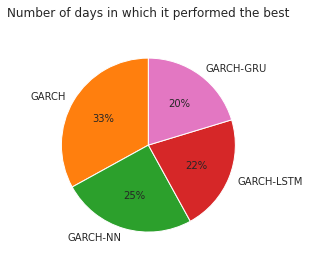

In [50]:
# Compare day by day

# error list
errors_hv = abs(target_vkospi - predictions_hv)
errors_nn = abs(target_vkospi - predictions_nn)
errors_lstm = abs(target_vkospi - predictions_lstm)
errors_gru = abs(target_vkospi - predictions_gru)

# count the best models
best_models = []
for i in range(len(errors_hv)):
    each_predictions = [errors_hv.iloc[i], errors_nn.iloc[i], errors_lstm.iloc[i], errors_gru.iloc[i]]
    best_models.append(each_predictions.index(min(each_predictions)))

best_counts = [best_models.count(i) for i in range(4)]

    
# plot
fig, ax = plt.figure(), plt.axes()
ax.pie(best_counts, labels=['GARCH','GARCH-NN','GARCH-LSTM','GARCH-GRU'], autopct='%.0f%%', startangle=90, colors=palette[1:])
plt.title('Number of days in which it performed the best')
plt.show()

### Number of predicting the right direction (up or down)

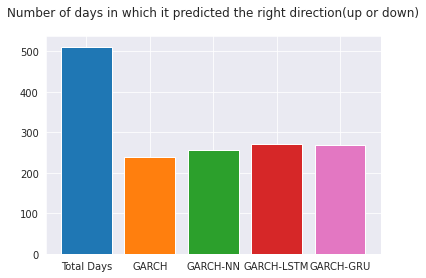

GARCH
46.771037181996086 %
GARCH-NN
50.09784735812133 %
GARCH-LSTM
53.22896281800391 %
GARCH-GRU
52.64187866927593 %


In [51]:
# direction arrays
directions_vkospi = target_vkospi - target_vkospi.shift()
directions_hv = predictions_hv - predictions_hv.shift()
directions_nn = predictions_nn - predictions_nn.shift()
directions_lstm = predictions_lstm - predictions_lstm.shift()
directions_gru = predictions_gru - predictions_gru.shift()

# multiplicate element-wise, and count the positivie elements
def count_pos(series):
    count = 0
    for x in series:
        if x>0:
            count += 1
    return count

direction_counts = [511,0,0,0,0]
direction_counts[1] = count_pos(directions_hv * directions_vkospi)
direction_counts[2] = count_pos(directions_nn * directions_vkospi)
direction_counts[3] = count_pos(directions_lstm * directions_vkospi)
direction_counts[4] = count_pos(directions_gru * directions_vkospi)

# plot
fig, ax = plt.figure(), plt.axes()
ax.bar(['Total Days','GARCH','GARCH-NN','GARCH-LSTM','GARCH-GRU'],direction_counts, color=palette)
plt.title('Number of days in which it predicted the right direction(up or down)')
plt.show()

# direction prediction accuracy
print('GARCH')
print(direction_counts[1] / direction_counts[0]*100,'%')
print('GARCH-NN')
print(direction_counts[2] / direction_counts[0]*100,'%')
print('GARCH-LSTM')
print(direction_counts[3] / direction_counts[0]*100,'%')
print('GARCH-GRU')
print(direction_counts[4] / direction_counts[0]*100,'%')